In [ ]:
"""
This file...
1. finds the cosine similarity between articles with at least 1 named entity 
2. filters down to only article pairs closer than 1 week 
3. creates a graph of articles with cosine sim. weighted edges
4. outputs connected components of that graph after considering only weighted edges above a certain 
similarity threshold
"""

In [26]:
from numpy import dot
import math
import pandas as pd
import numpy as np
from ast import literal_eval
import re
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance 
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import seaborn as sns
from tqdm import tqdm 
import networkx as nx
import pickle

In [27]:
#NOTE: very important, which entity categories to keep 
#article showing all entity types below
# https://www.kaggle.com/code/curiousprogrammer/entity-extraction-and-classification-using-spacy
TO_KEEP = ["org","event", "person", "work_of_art", "product"]

#only keep named entities that have a # of articles associated with them in this range 
CLUSTER_CUTOFF = [2, 20000]

#this is the lowest cosine similarity threshold we will use 
SIM_THRESH = .8

INVERTED_ENT_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/invertedEntityIndex.pkl"
EMBEDS_PATH = "/shared/3/projects/newsDiffusion/data/processed/articleEmbeddings/embeddings.pkl"
CLEANED_DF_PATH = "/shared/3/projects/newsDiffusion/data/processed/newsData/fullDataWithNERCleaned.tsv"

#how many days apart do we allow our articles to be? 
#if we consider adding edge between them based on cosine similarity 
#7 allows for Sunday - Sunday but NOT Sunday - Monday of following week 
DATE_FILTER = 7

## Load data

In [29]:
#this is the df with our inverted index in it
invertedDf = pd.read_pickle(INVERTED_ENT_PATH)

In [ ]:
#what are the entities with the top number of associated articles 
invertedDf.sort_values("numArticles", ascending=False).head()

In [31]:
print(f"len before filtering: {len(invertedDf)}")
invertedDf = invertedDf[(invertedDf["numArticles"] >= CLUSTER_CUTOFF[0]) & (invertedDf["numArticles"] <= CLUSTER_CUTOFF[1])]
print(f"len after filtering: {len(invertedDf)}")

len before filtering: 7436473
len after filtering: 2614176


In [32]:
max(invertedDf["numArticles"])

19817

In [8]:
#a dictionary so we can get the embeddings we need quickly 
#embeddingsDict = embeddingsDf.set_index("key").to_dict(orient="index")
embedsFile = open(EMBEDS_PATH, "rb")
embeddingsDict = pickle.load(embedsFile)

In [33]:
#get a list of the keys that correspond to each named entity 
#sort so that smaller clusters will be processed first :) 
keyOptions = list(invertedDf.sort_values("numArticles", ascending=False)["key"])

## Get cosine similarity 

In [35]:
#very simple, go through each list of articles associated with our named entities
#next, get cosine similarity, and store only those articles where cosine sim is > .8 

simList = []
lKeyList = []
rKeyList = []

#for each list of article keys associated with entities 
for i, entGroup in enumerate(tqdm(keyOptions)): 
    
    #within each list of article keys, consider the unique pairs 
    #and get their cosine similarities 
    #for i in range(0, len(entGroup)): 
    myMat = np.matrix([embeddingsDict[key]["embedding"] for key in entGroup])
    pairSims = cosine_similarity(myMat).flatten()
    entGroup = np.array(entGroup)
    
    greaterThan = np.where(pairSims > .8)
    simList.append(pairSims[greaterThan])
    
    #get the equivalent row and column indices to what we have in the flattened array 
    left = [math.floor(index / len(entGroup)) for index in greaterThan[0]]
    right = [index % len(entGroup) for index in greaterThan[0]]
    
    #get the keys corresponding to the elements we selected from the list 
    lKeyList.append(entGroup[left])
    rKeyList.append(entGroup[right])
    


100%|██████████| 2614176/2614176 [43:32<00:00, 1000.72it/s]


In [36]:
#concatenate all of the lists of np arrays we made 
simCat = np.concatenate(simList)
lKeyCat = np.concatenate(lKeyList)
rKeyCat = np.concatenate(rKeyList)

In [37]:
#this dataframe gives us the article pair (left,right keys) and the similarity for that pair
#in long format 
pairsDf = pd.DataFrame({"lKey":lKeyCat, "rKey":rKeyCat,"simScore":simCat})

In [15]:
#quick sanity check
#does a random pair have the same similarity as if we recompute it directly 
randIndex = 56566740
randRow = pairsDf.loc[randIndex]

1 - cosine(embeddingsDict[randRow["lKey"]]["embedding"], embeddingsDict[randRow["rKey"]]["embedding"])

1

In [16]:
#same thing!
#check passes 
randRow["simScore"]

1.0000000000000009

(array([59479338., 46855108., 36062156., 27001246., 19874420., 14838914.,
        13012390., 14586432., 31507106., 54381700.]),
 array([0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 10 artists>)

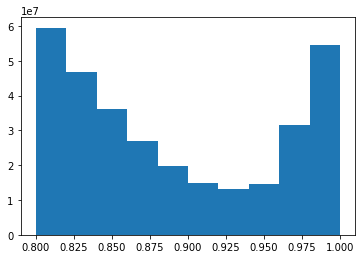

In [128]:
#get a distribution over similarity scores 
plt.hist(pairsDf["simScore"])

## Apply date filter 

In [38]:
#get only unique pairs of articles 
pairsUnique = pairsDf.drop_duplicates(subset=["lKey", "rKey"])
artsDf = pd.read_csv(CLEANED_DF_PATH,usecols=["key", "date"], sep="\t")

#get a dictionary that has articles as keys and dates as values 
artsDf["date"] = pd.to_datetime(artsDf["date"])
dateDict = artsDf.set_index("key").to_dict(orient="index")

In [23]:
import math 
import numpy as np

In [41]:
#get only the date indices that are a week or less apart  
lKeys = pairsDf["lKey"]
rKeys = pairsDf["rKey"]

dateIndices = []
for i in tqdm(range(len(pairsDf))): 
    lDate = dateDict[lKeys[i]]["date"]
    rDate = dateDict[rKeys[i]]["date"]
    
    dateDist = (rDate - lDate).days
    
    #so we can have Sunday - Sunday but not Sunday - Monday 
    if np.abs(dateDist) < DATE_FILTER: 
        dateIndices.append(i)

100%|██████████| 317598810/317598810 [1:23:32<00:00, 63363.30it/s]  


In [42]:
#the remaining pairs 
datePairs = pairsDf.iloc[dateIndices]

In [43]:
len(datePairs) / len(pairsDf)

0.5680837721022948

## Generate connected components, write to file(s)

In [44]:
#we want to be able to work with multiple cutoffs if need be, so output data for these cutoffs accordingly 
#file paths include the Named Entity cutoff as well as the cosine sim. cutoff 
BASE_PATH = "/shared/3/projects/newsDiffusion/data/interim/NEREmbedding/"
OUT_PATHS = ["embeddingClusterDf_2_20000_80.tsv", "embeddingClusterDf_2_20000_85.tsv", "embeddingClusterDf_2_20000_90.tsv"]
CUTOFFS = [.80, .85, .90]

for i, cutoff in enumerate(tqdm(CUTOFFS)): 
    outPath = BASE_PATH + OUT_PATHS[i]
    overThresh = datePairs[datePairs["simScore"] >= cutoff]
    graph = nx.from_pandas_edgelist(overThresh[["lKey", "rKey"]], "lKey", "rKey")

    components = nx.connected_components(graph)
    compList = [comp for comp in components]

    clusters = pd.DataFrame({"cluster":compList}) #.reset_index()

    #we can remove clusters of size one 
    clusters["clustSize"] = clusters["cluster"].apply(lambda x: len(list(x)))

    print(f'first 10:\n{sorted(clusters["clustSize"], reverse=True)[:10]}')
    
    clusters = clusters[clusters["clustSize"] > 1]

    clusters["clustNum"] = list(range(0, len(clusters)))

    clustDf = clusters.explode("cluster").rename(columns={"index":"clustNum", "cluster":"key"})

    clustSizes = pd.DataFrame(clustDf["clustNum"].value_counts()).reset_index()

    clustSizes.value_counts()
    
    #write our clusters to output file 
    clustDf.to_csv(outPath, sep="\t")

  0%|          | 0/3 [00:00<?, ?it/s]

first 10:
[237930, 38855, 6731, 6504, 5848, 4166, 3341, 3240, 3137, 3125]


 33%|███▎      | 1/3 [05:24<10:48, 324.40s/it]

first 10:
[20275, 7206, 5768, 5653, 4108, 3599, 3376, 3093, 2406, 2312]


 67%|██████▋   | 2/3 [09:57<04:54, 294.20s/it]

first 10:
[1378, 1026, 737, 622, 525, 516, 477, 464, 442, 391]


100%|██████████| 3/3 [13:48<00:00, 276.07s/it]
